Plan:
* Analzye the temperautre and currents for all SVP drifters deployed on NL Shelf since about 2019

In [1]:
import glob
import os

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import xarray as xr
import yaml

from plotutils.drift_correction_factor import dcf_rotary_spectra

In [2]:
drifterID_file = 'NLDrifterIDs.yaml'
with open(drifterID_file) as f:
    deployments = yaml.safe_load(f)

In [3]:
deployments.keys()

dict_keys(['LaurentionChannel', 'NLRegion2021', 'Arctic2022', 'NLSpringAZMP2022', 'NLFallAZMP2022', 'NLSpringAZMP2023', 'NLSummerAZMP2023', 'StudentsonIce2023', 'NLFallAZMP2023', 'NLSummerAZMP2024', 'StudentsonIce2024'])

In [4]:
ds = ['NLRegion2021', 'Arctic2022', 'NLSpringAZMP2022', 'NLFallAZMP2022', 'NLSpringAZMP2023',
      'NLSummerAZMP2023', 'StudentsonIce2023', 'NLFallAZMP2023', 
      'NLSummerAZMP2024',  'StudentsonIce2024']
data_dir = 'INSITU_GLO_PHY_UV_DISCRETE_NRT_013_048/cmems_obs-ins_glo_phy-cur_nrt_drifter_irr_202311' 

In [5]:
def gather_data(ID):
    """Open xarray dataset for files associated with a drifter ID"""
    files = glob.glob(os.path.join(data_dir, 'monthly', '*', f'*{ID}*.nc'))
    if not files:
        files = glob.glob(os.path.join(data_dir, 'latest', '*', f'*{ID}*.nc'))
    if not files:
        print(f'No files found for ID {ID}')
        return None
    d = xr.open_mfdataset(files)
    return d

In [6]:
def plot_dataset_timeseries(d, ax, var='TEMP'):
    """Plot var timeseries for a dataset"""
    if var == 'TEMP':
        dind = 1
    if var == 'EWCT' or var == 'NSCT':
        dind = 2
    if var == 'WSPE_MODEL' or var == 'WSPN_MODEL':
        dind = 0
    dqc = d.where(d[f'{var}_QC']==1)
    data = dqc[var].isel(DEPTH=dind).values
    ax.plot(dqc.TIME, data)
    ax.set_ylabel(f'{d[var].long_name}\n[{d[var].units}]')

In [7]:
def plot_map(d,ax,vmin=4, vmax=16):
    mesh = ax.scatter(d.LONGITUDE.values, d.LATITUDE.values, c=d.sel(DEPTH=1).TEMP.values,
                      vmin=vmin, vmax=vmax, transform=ccrs.PlateCarree())
    return mesh

In [8]:
def plot_gridspec(d):
    fig = plt.figure(constrained_layout=True, figsize=(14,10))
    gs = fig.add_gridspec(3, 2)
    #map
    axmap = fig.add_subplot(gs[0:2, 1], projection=ccrs.PlateCarree())
    d = gather_data(ID)
    mesh  = plot_map(d,axmap,vmin=d.TEMP.min().values, vmax=d.TEMP.max().values)
    cbar = plt.colorbar(mesh, ax=axmap)
    cbar.set_label(f'{d.TEMP.long_name} [{d.TEMP.units}]')
    axmap.coastlines()
    axmap.gridlines(draw_labels=['bottom', 'left'])
    #time series
    axv = fig.add_subplot(gs[2, 0])
    plot_dataset_timeseries(d,axv, var='NSCT')
    axv.tick_params(axis='x', labelrotation=90)
    axt = fig.add_subplot(gs[0, 0], )
    plot_dataset_timeseries(d,axt, var='TEMP')
    axu = fig.add_subplot(gs[1, 0])
    plot_dataset_timeseries(d,axu, var='EWCT')
    axt.get_xaxis().set_ticklabels([])
    axu.get_xaxis().set_ticklabels([])
    for ax in [axt, axu, axv]:
        ax.grid()
    
    fig.suptitle(ID)
    return fig

No files found for ID 4403561
No files found for ID 4403564
No files found for ID 4403566
No files found for ID 4403563
No files found for ID 4403565
No files found for ID 4403567
No files found for ID 4403562
No files found for ID 4403560
No files found for ID 4403570
No files found for ID 4403571
No files found for ID 4403572
No files found for ID 4403573
No files found for ID 4403574
No files found for ID 4403575
No files found for ID 4403576
No files found for ID 4403577


/tmp/ipykernel_2447050/4188935182.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(constrained_layout=True, figsize=(14,10))


No files found for ID 6801853
No files found for ID 3801659
No files found for ID 2802046
No files found for ID 4804079
No files found for ID 4804080
No files found for ID 3801660
No files found for ID 2802045
No files found for ID 6801852
No files found for ID 6801875
No files found for ID 3801759
No files found for ID 6801975
No files found for ID 2802157
No files found for ID 2802158
No files found for ID 7811001
No files found for ID 2802159


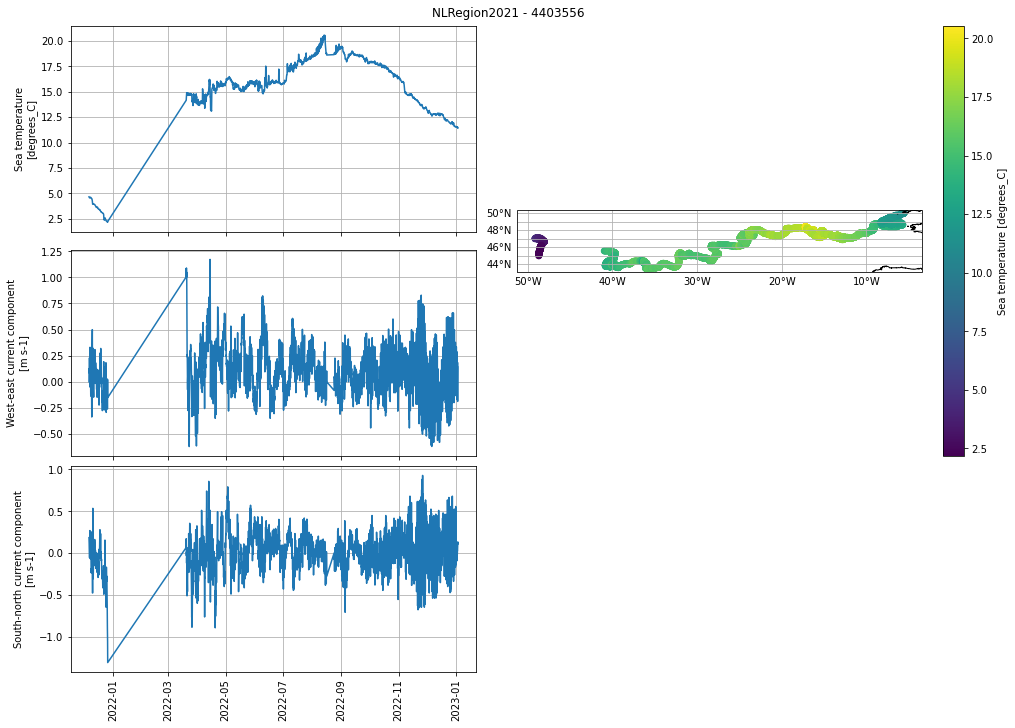

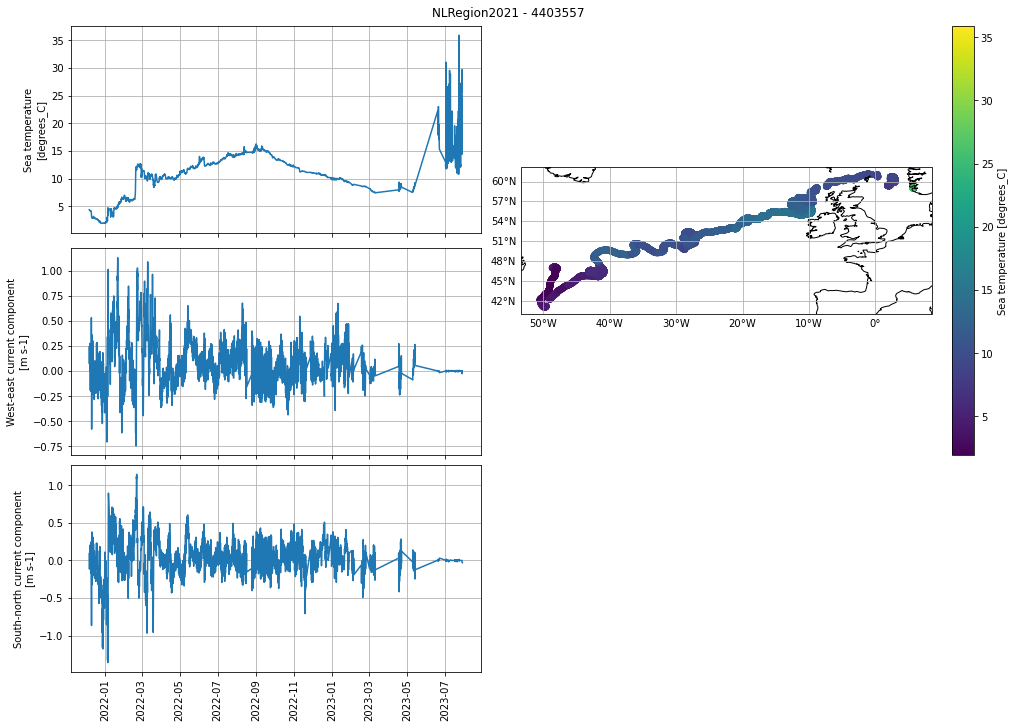

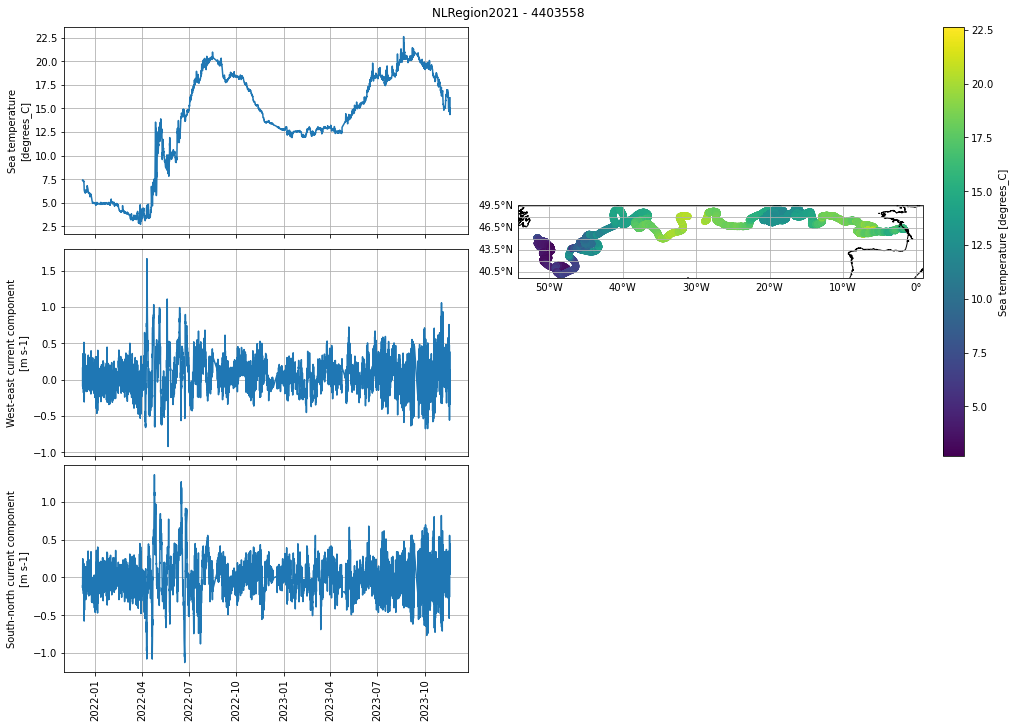

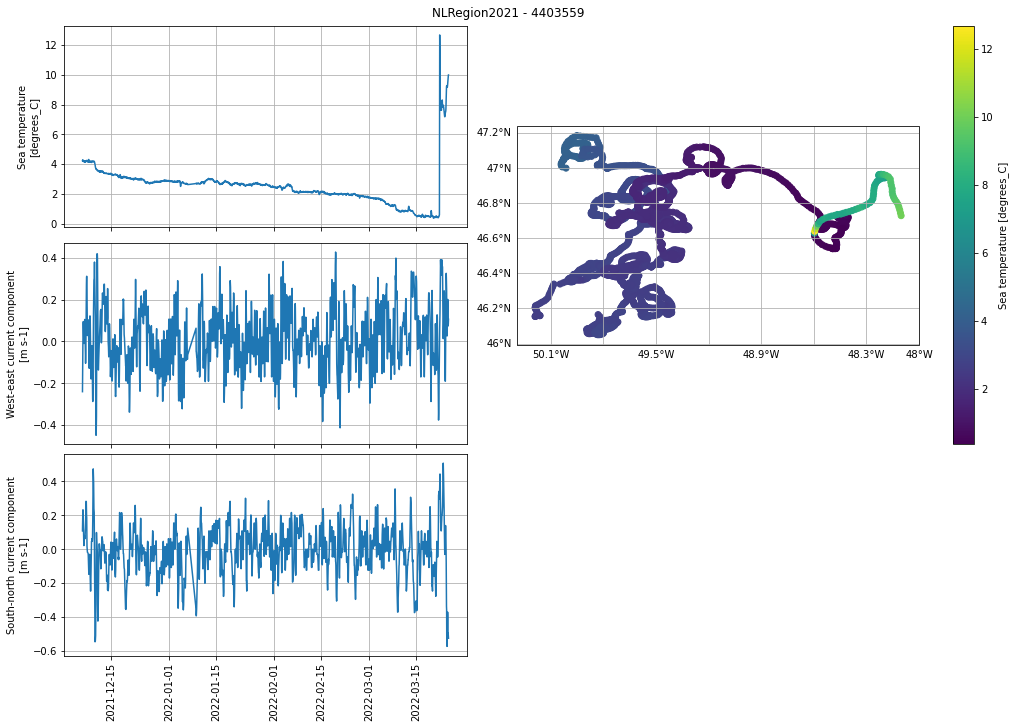

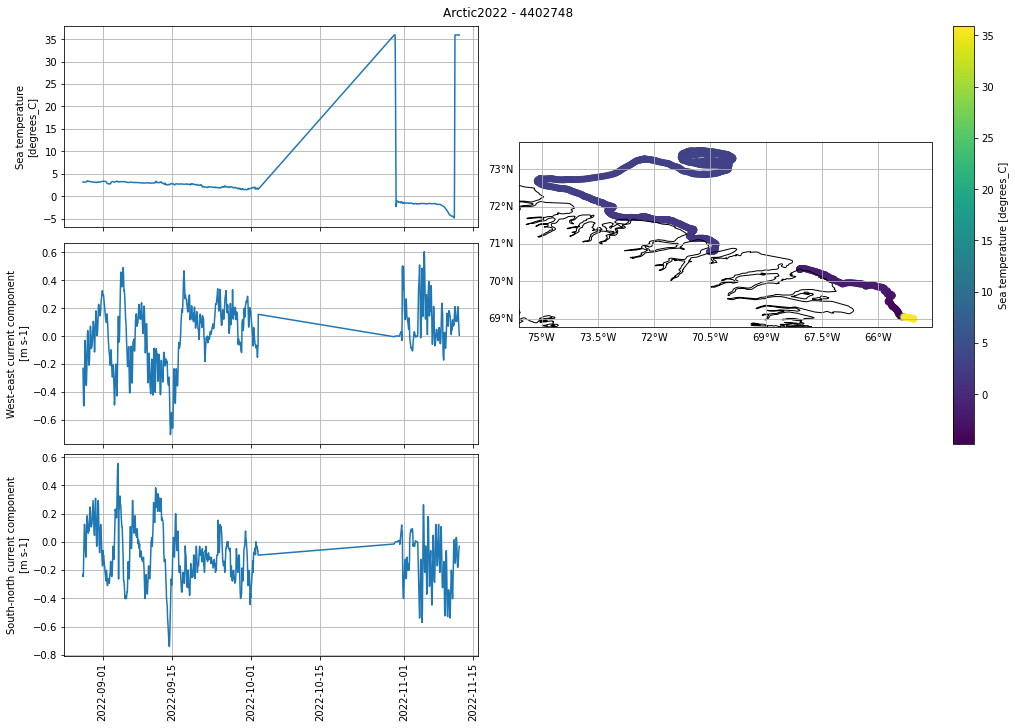

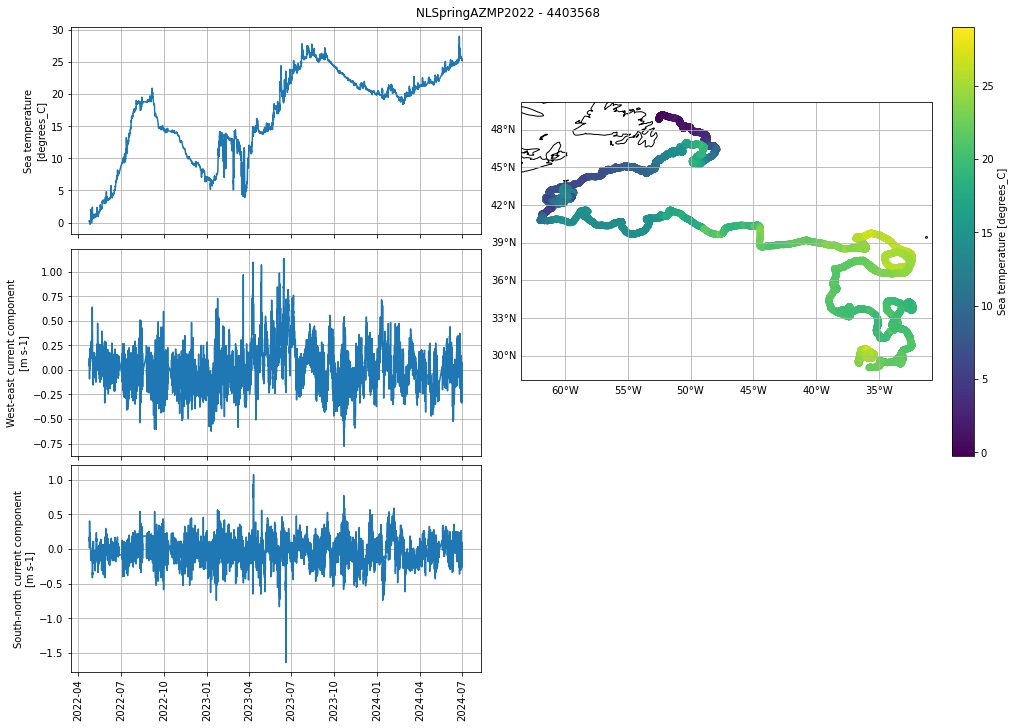

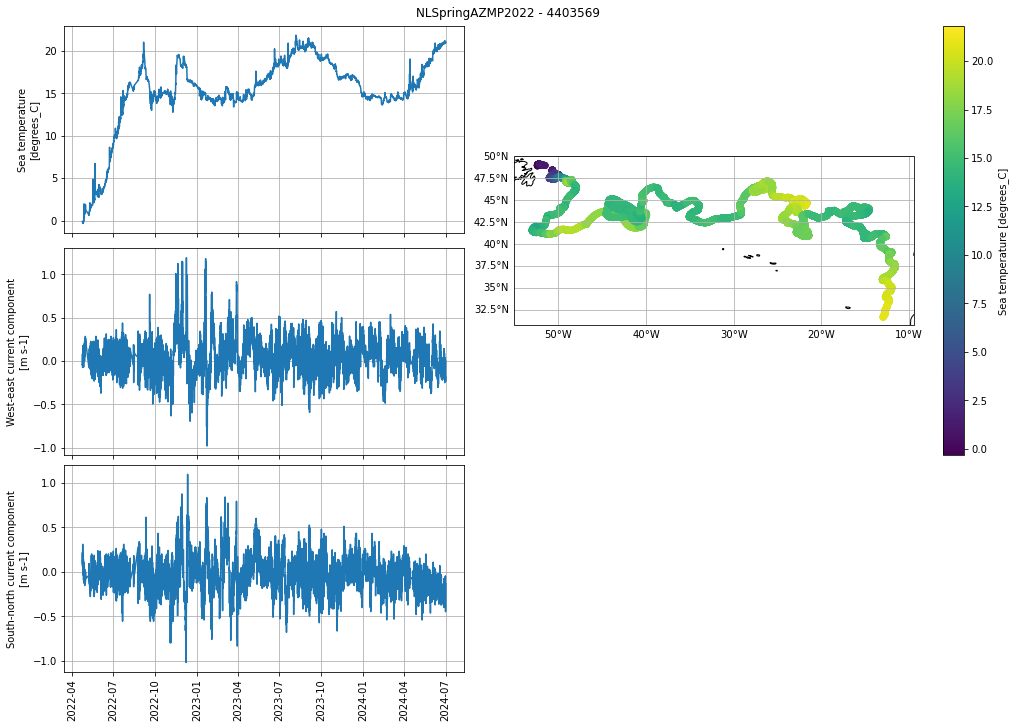

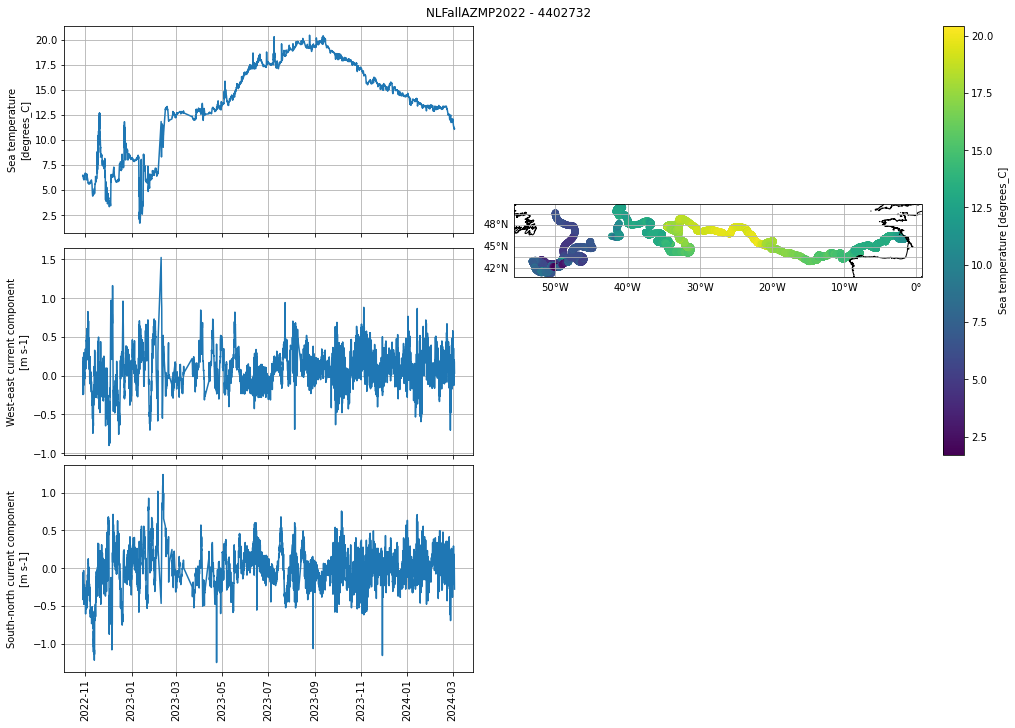

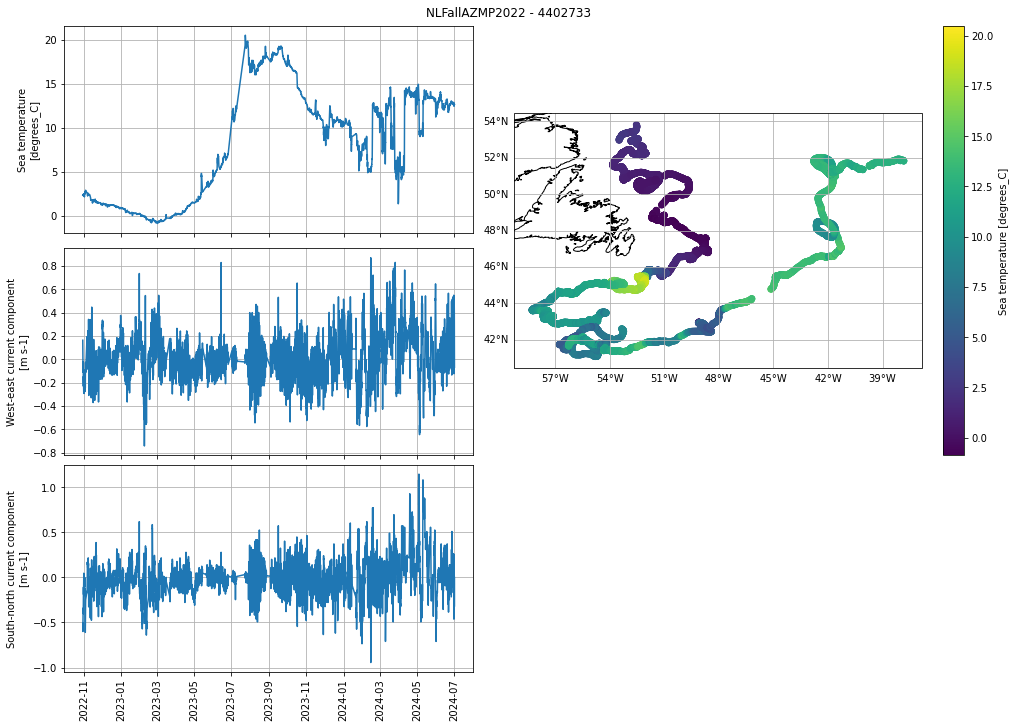

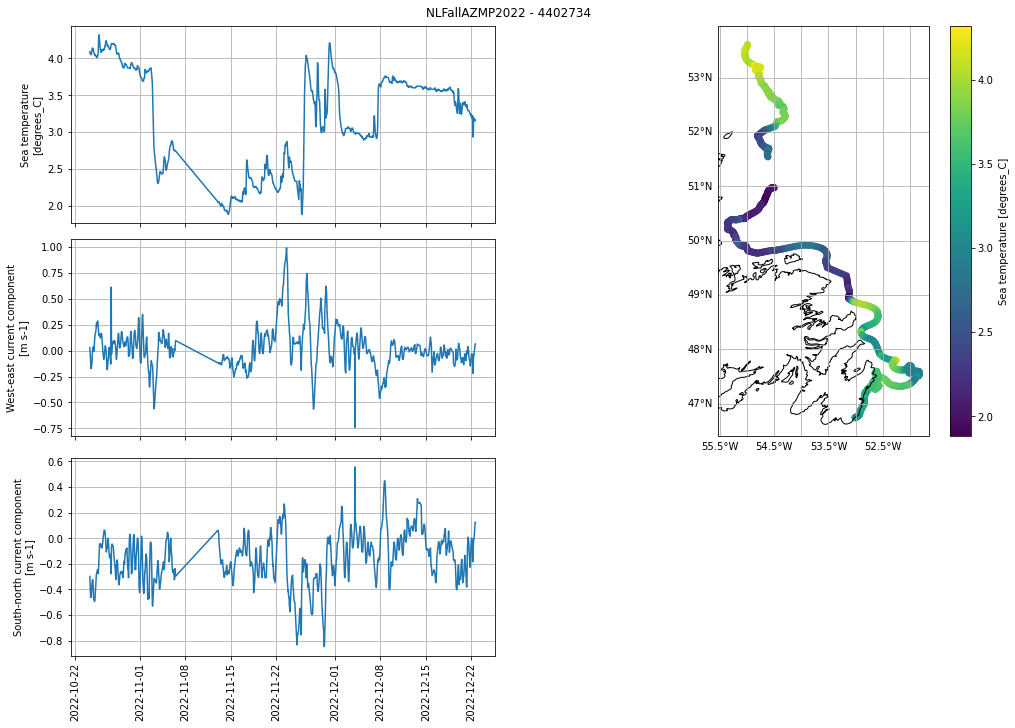

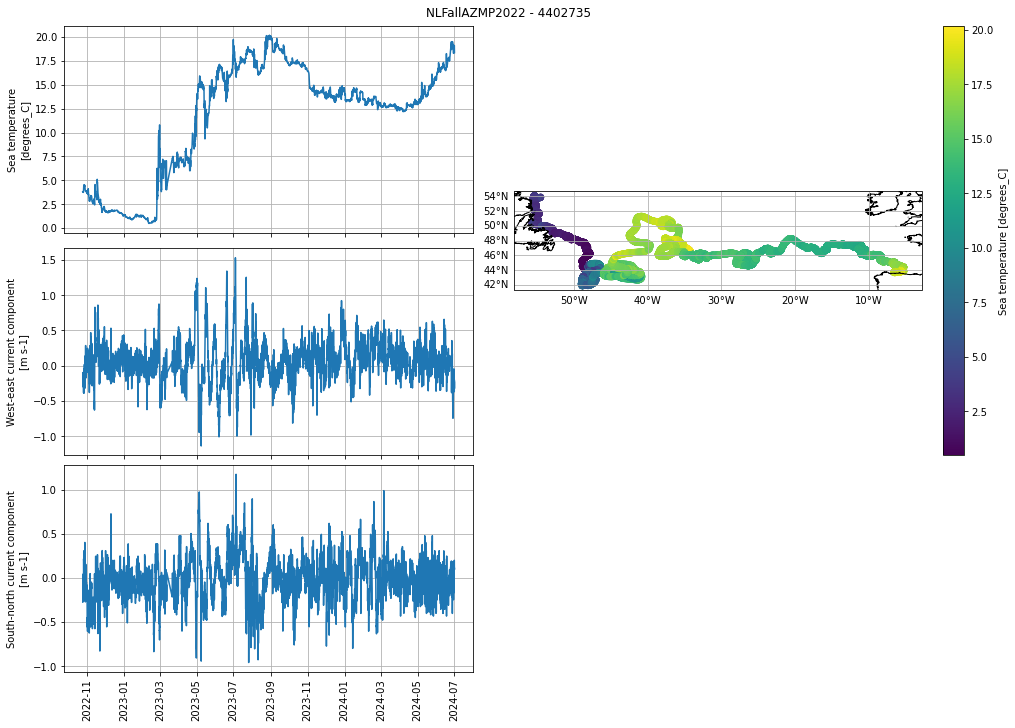

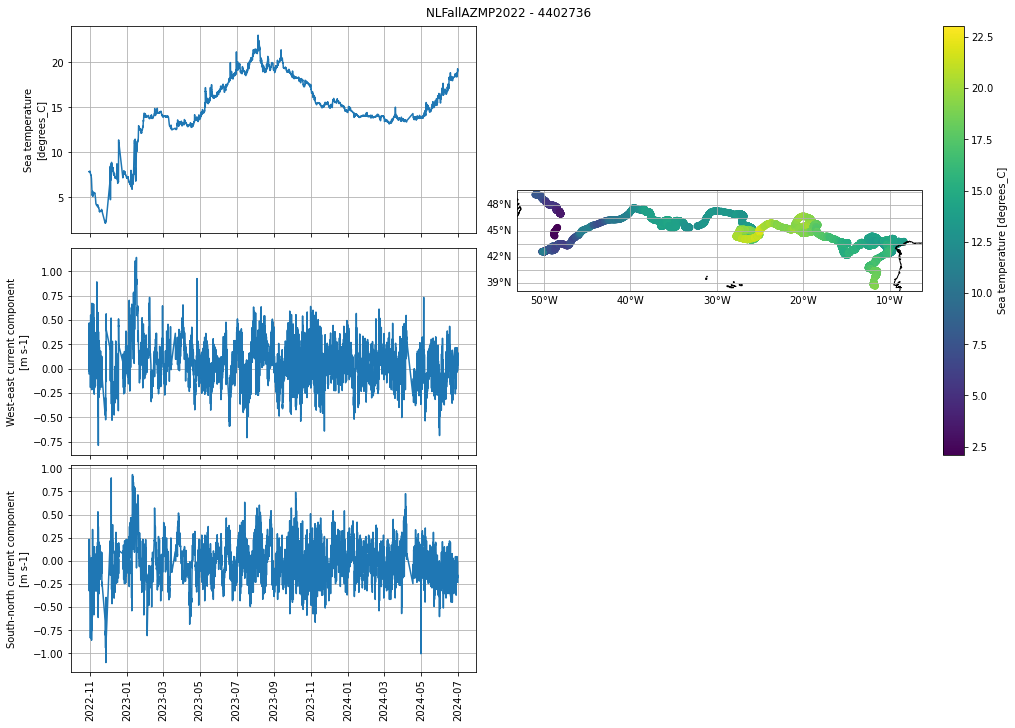

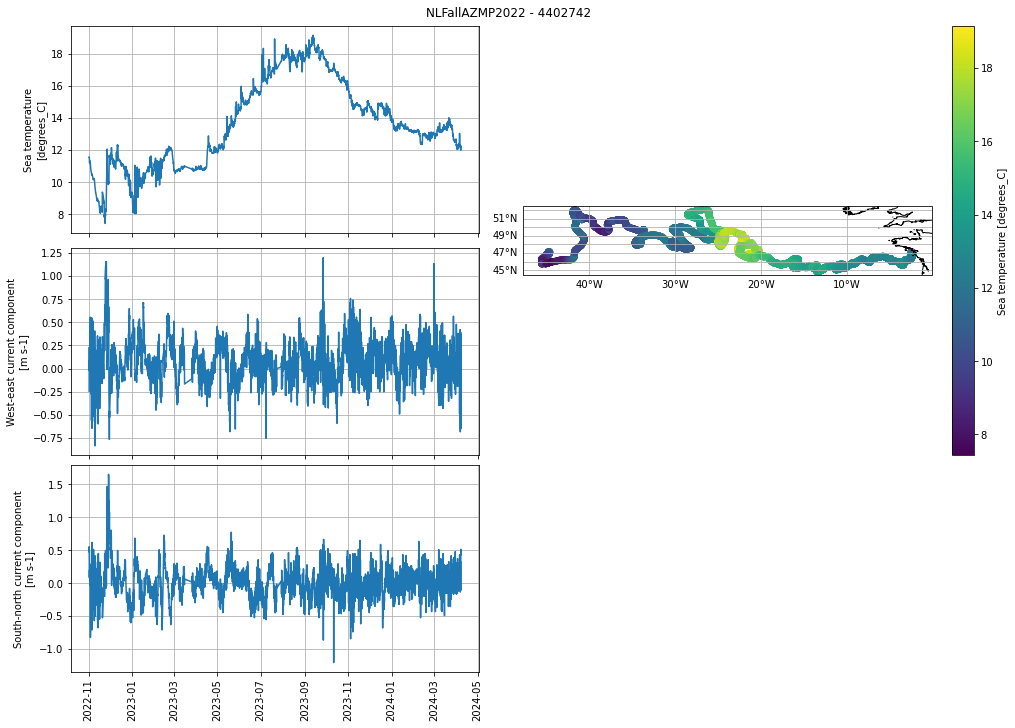

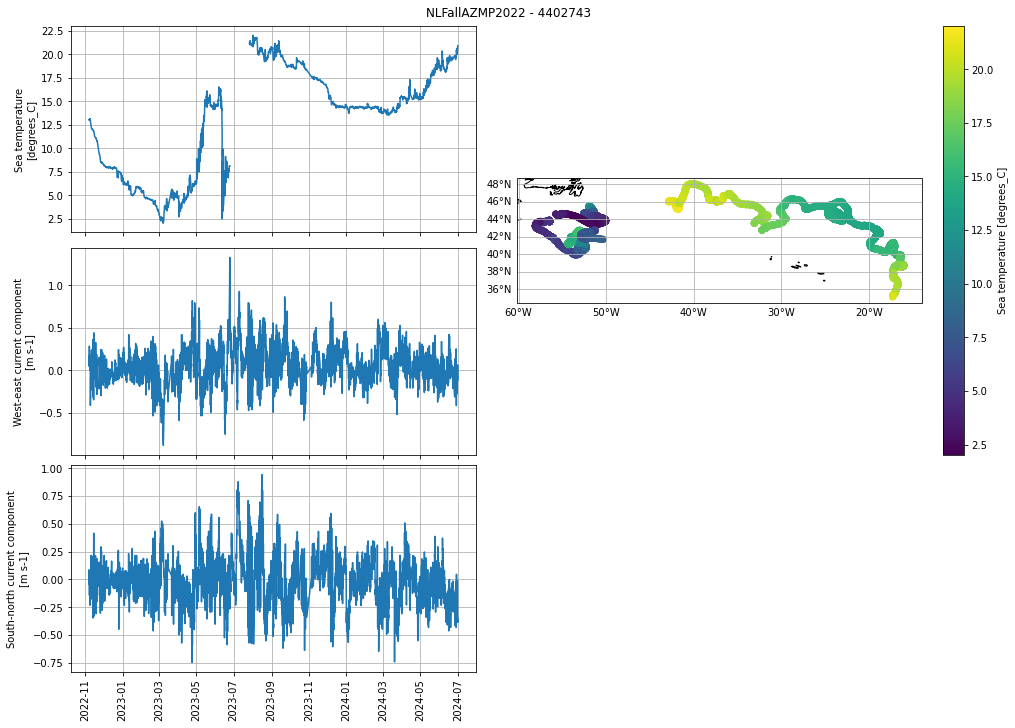

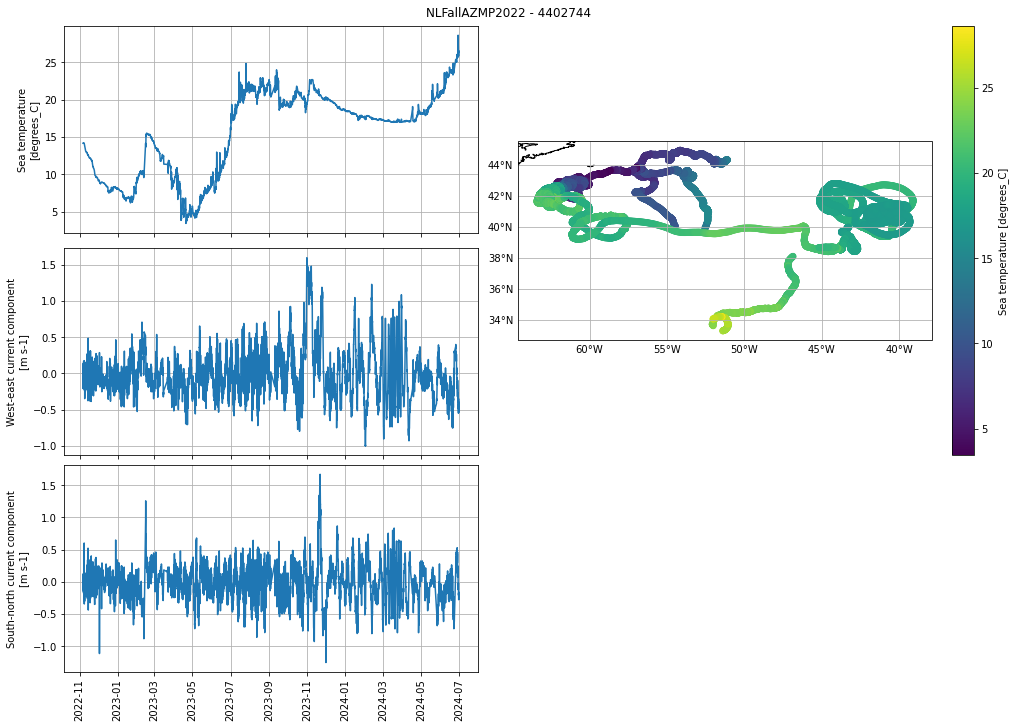

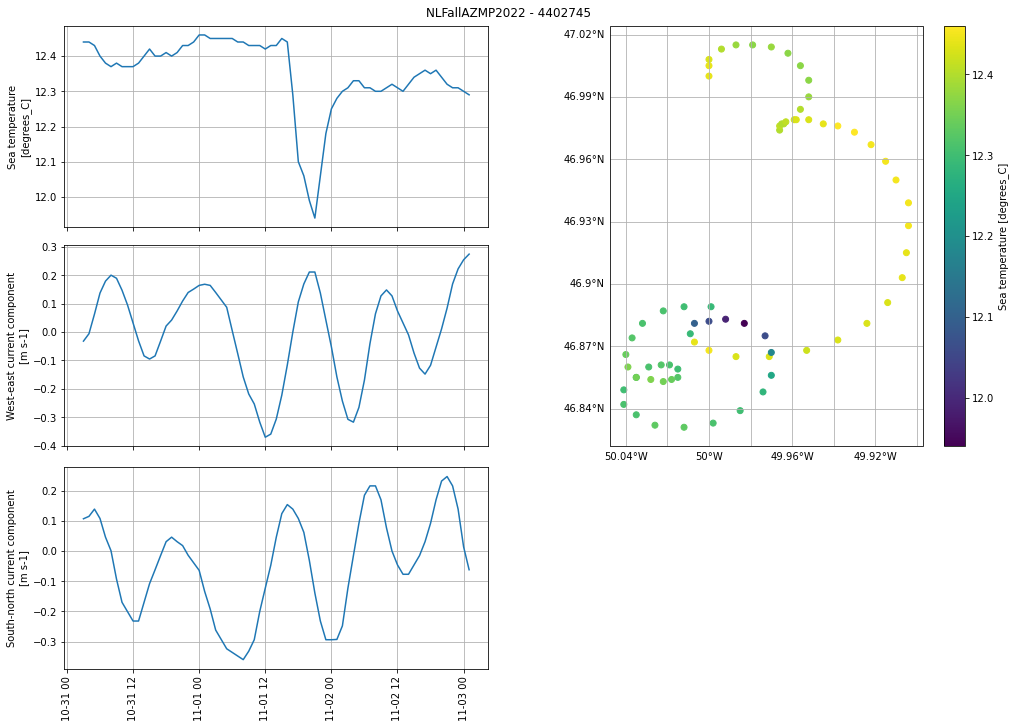

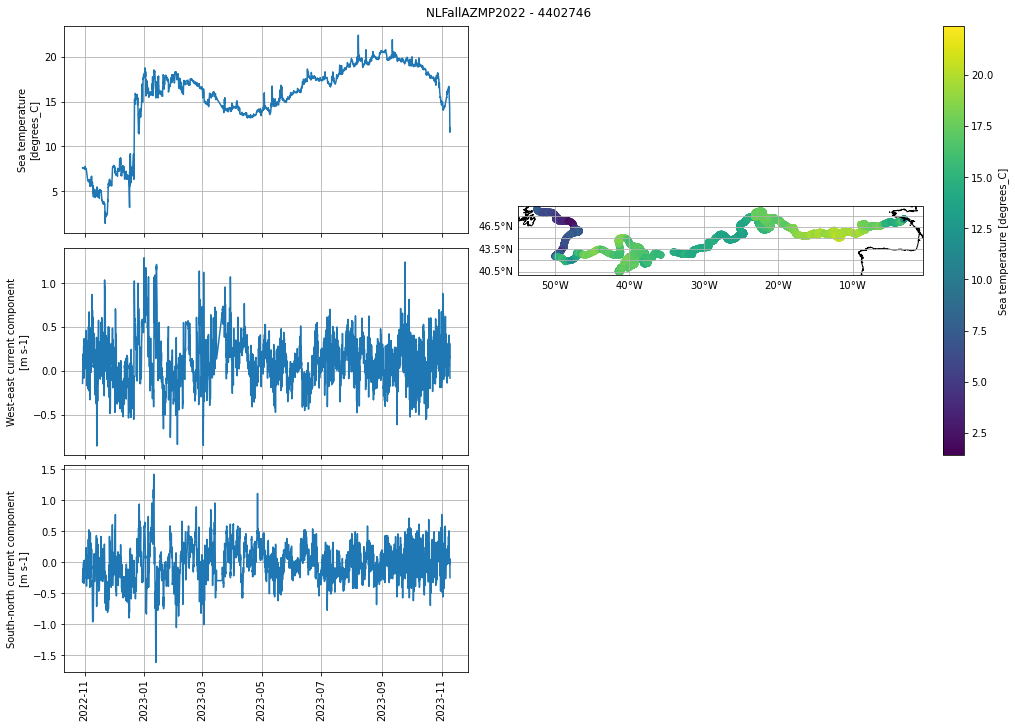

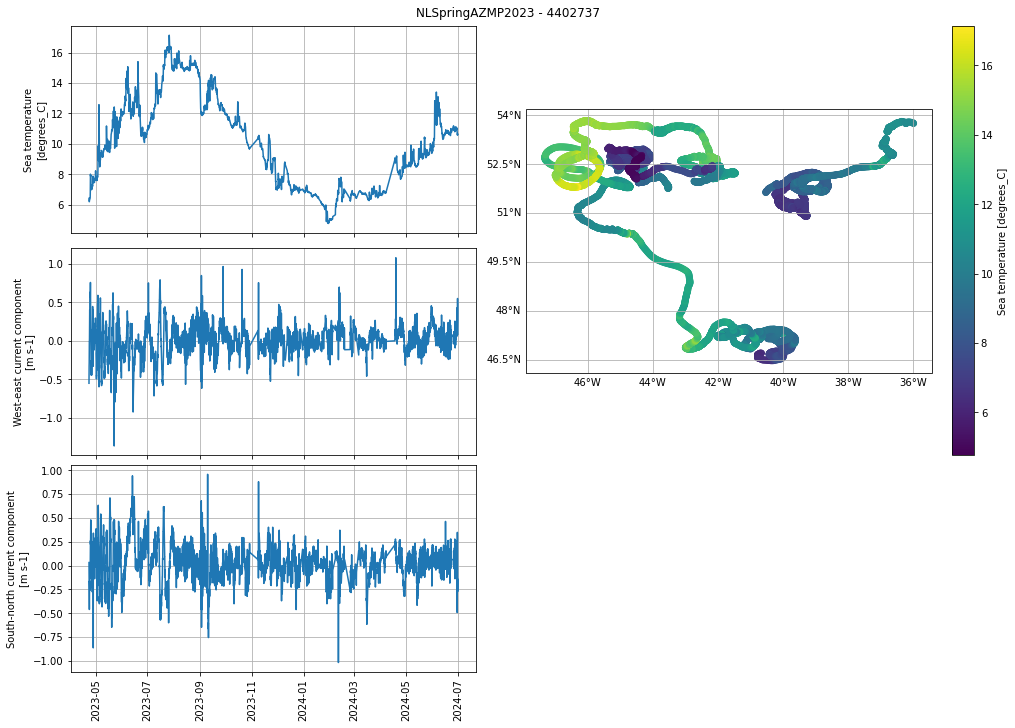

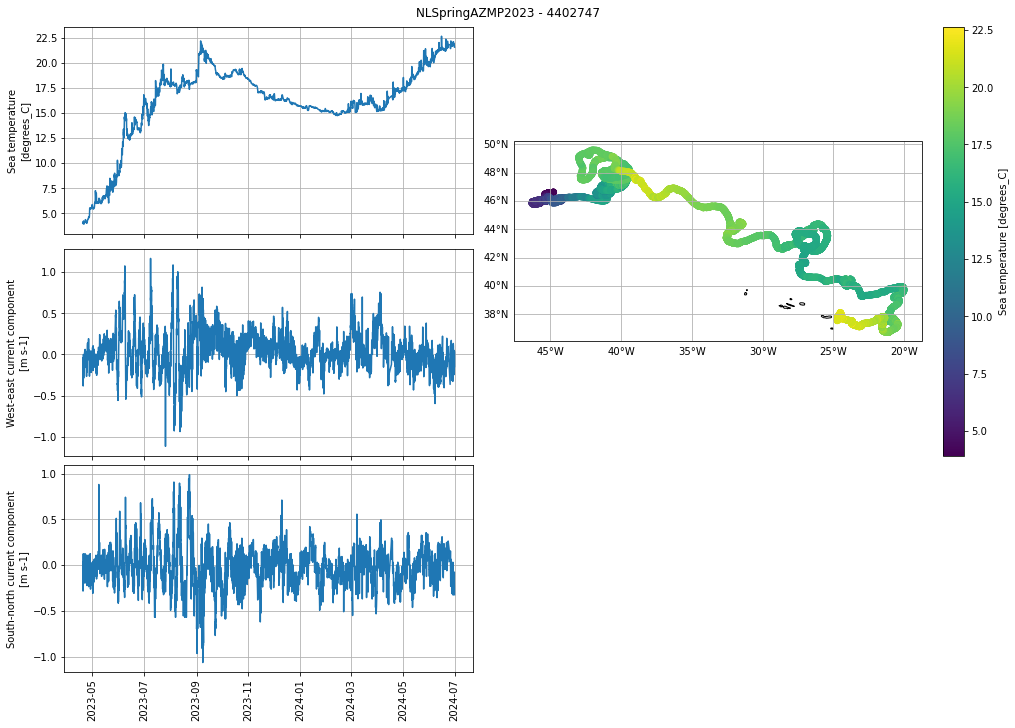

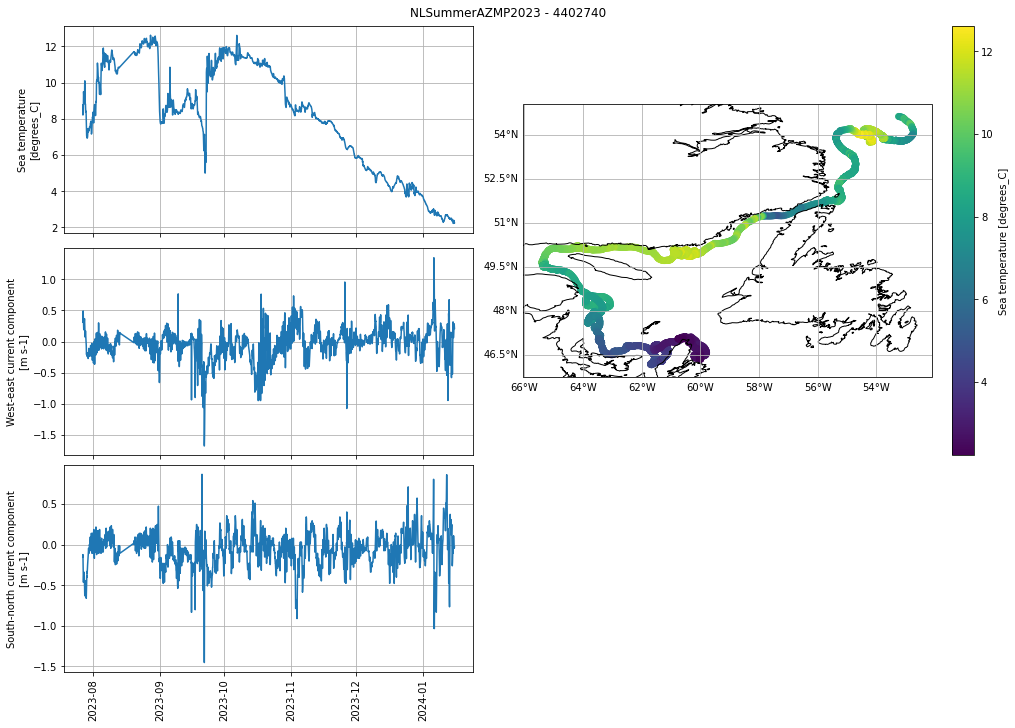

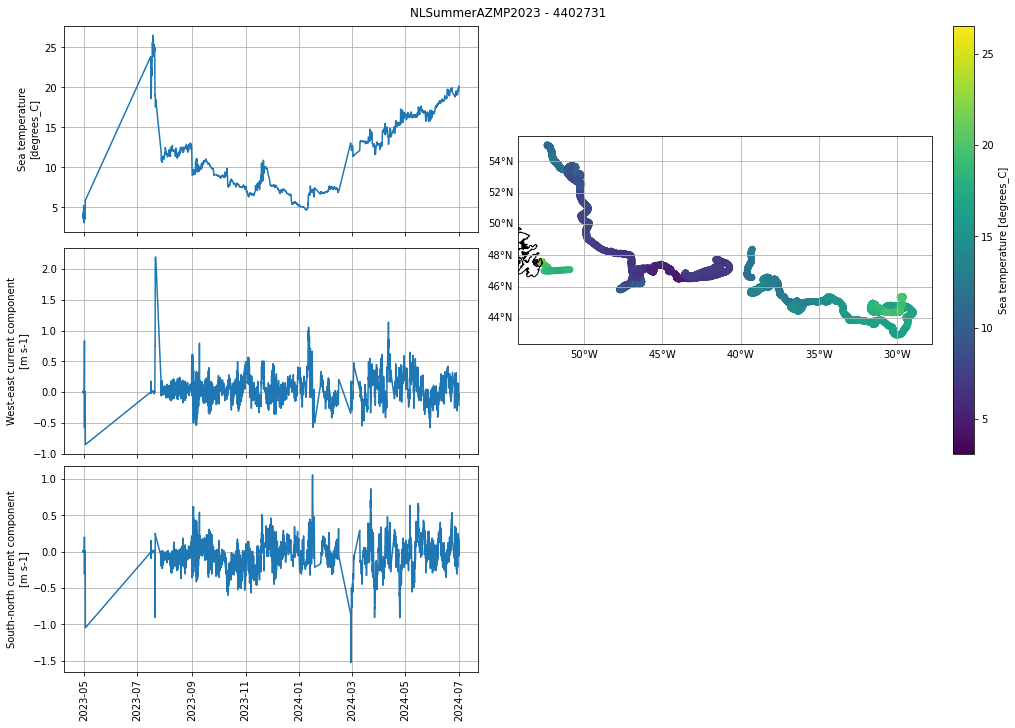

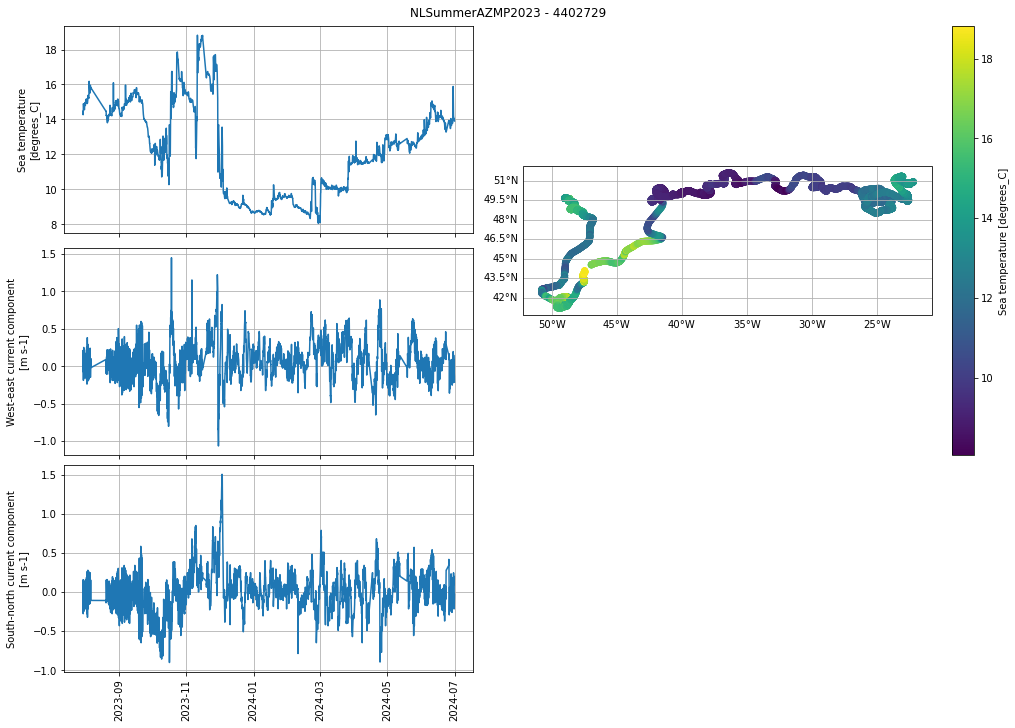

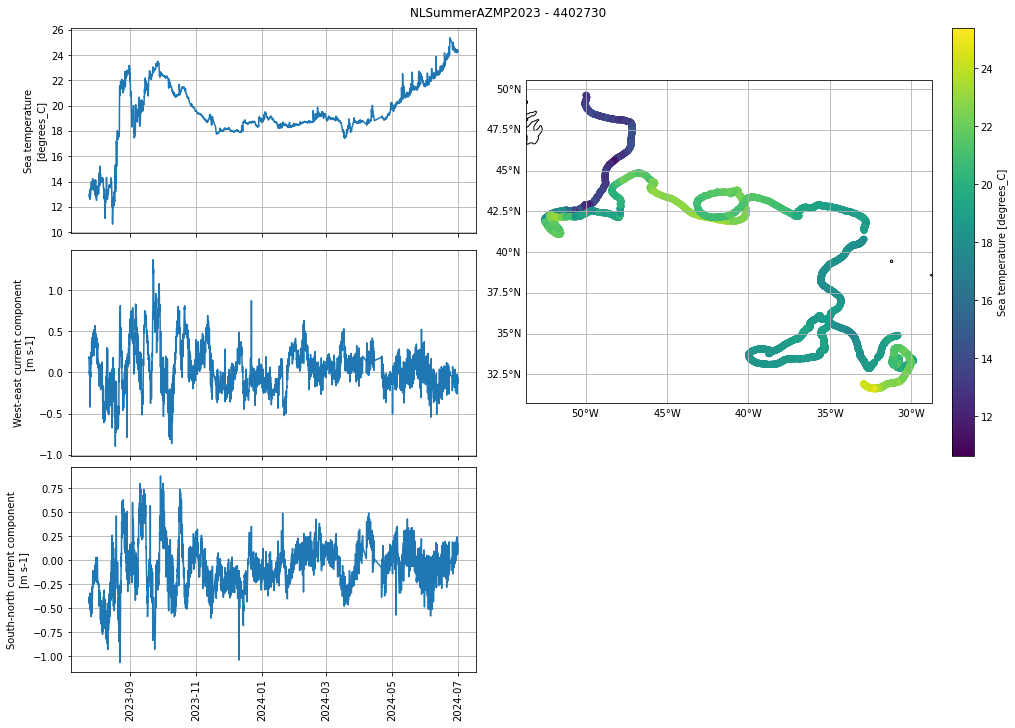

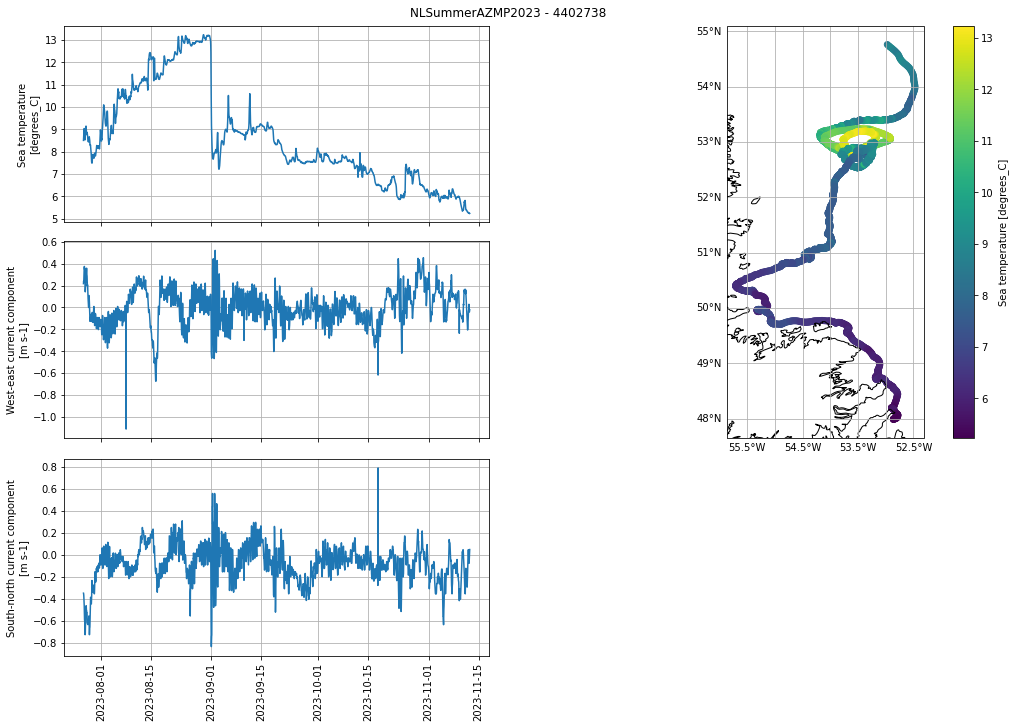

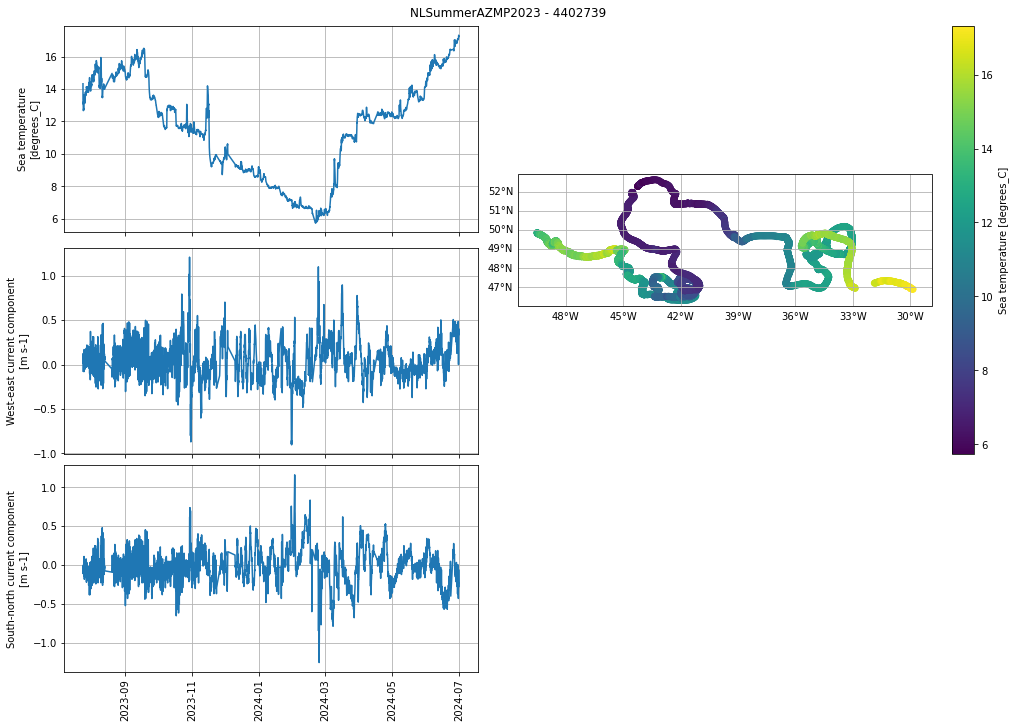

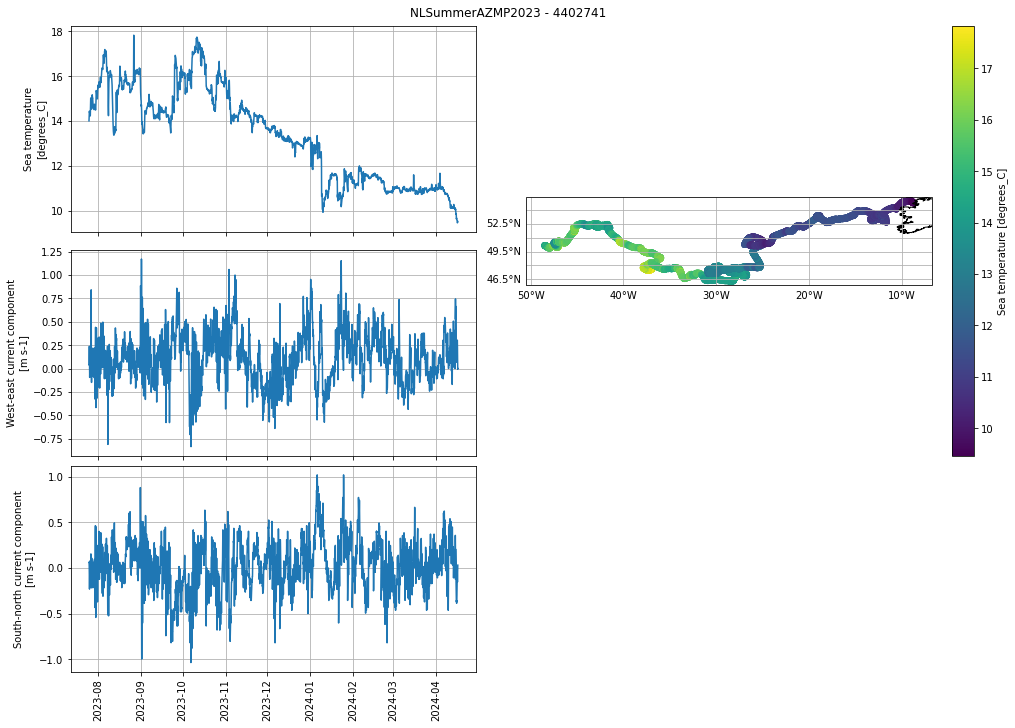

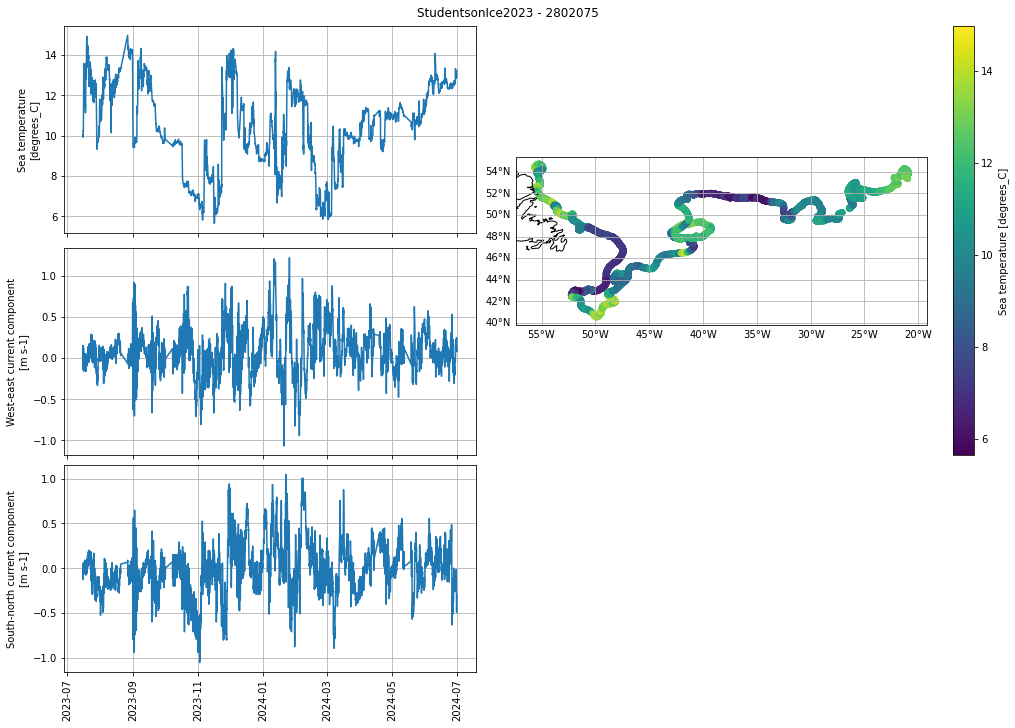

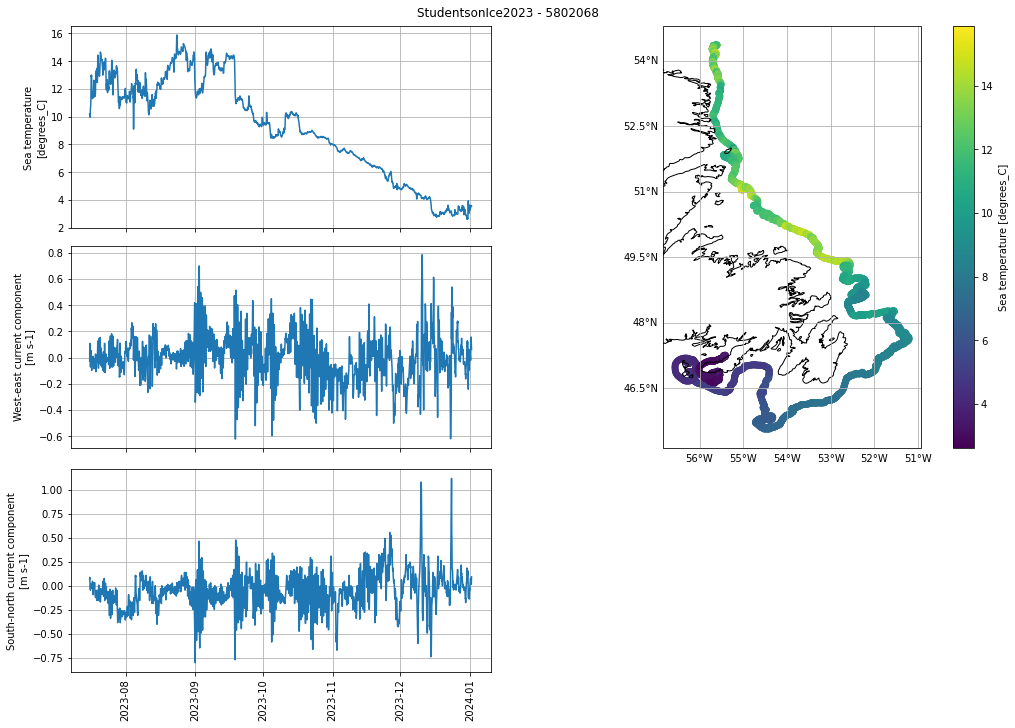

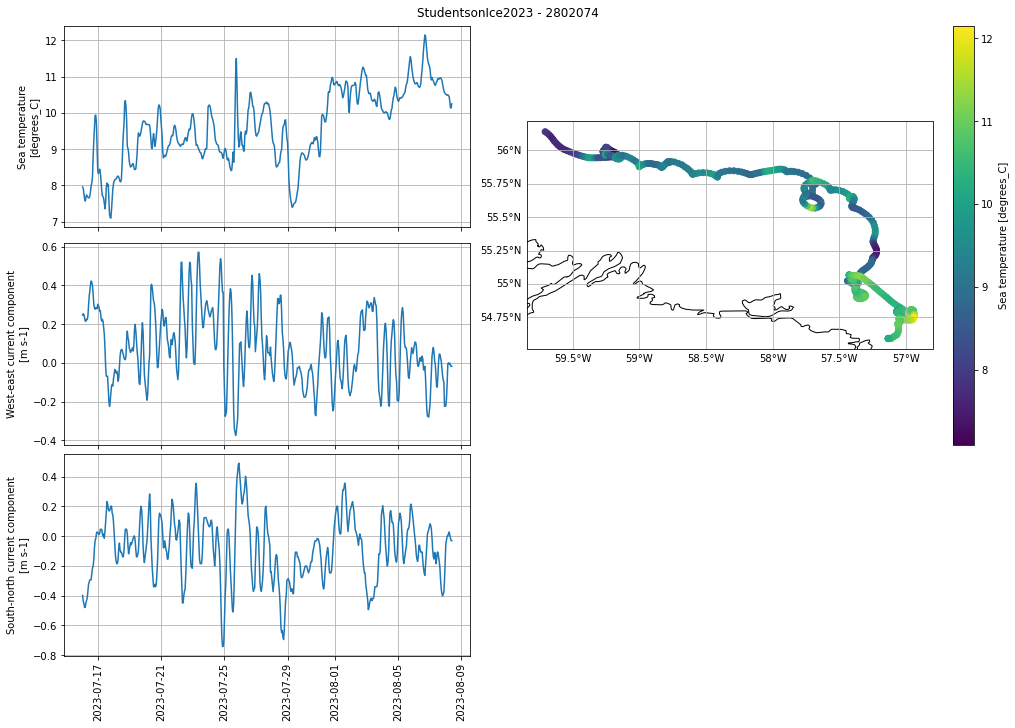

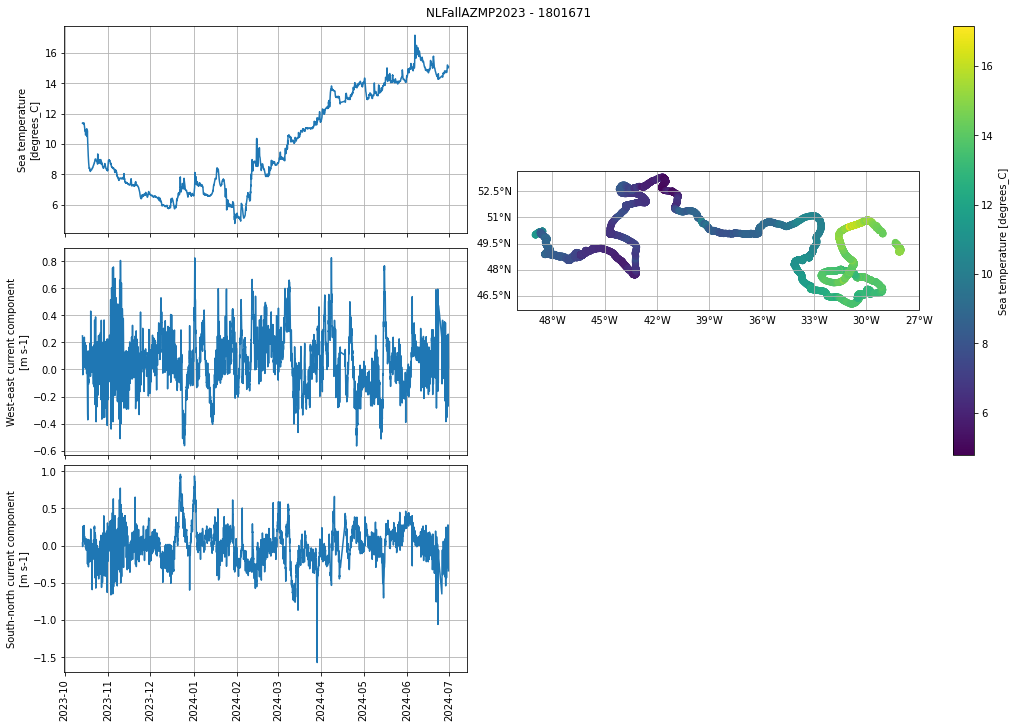

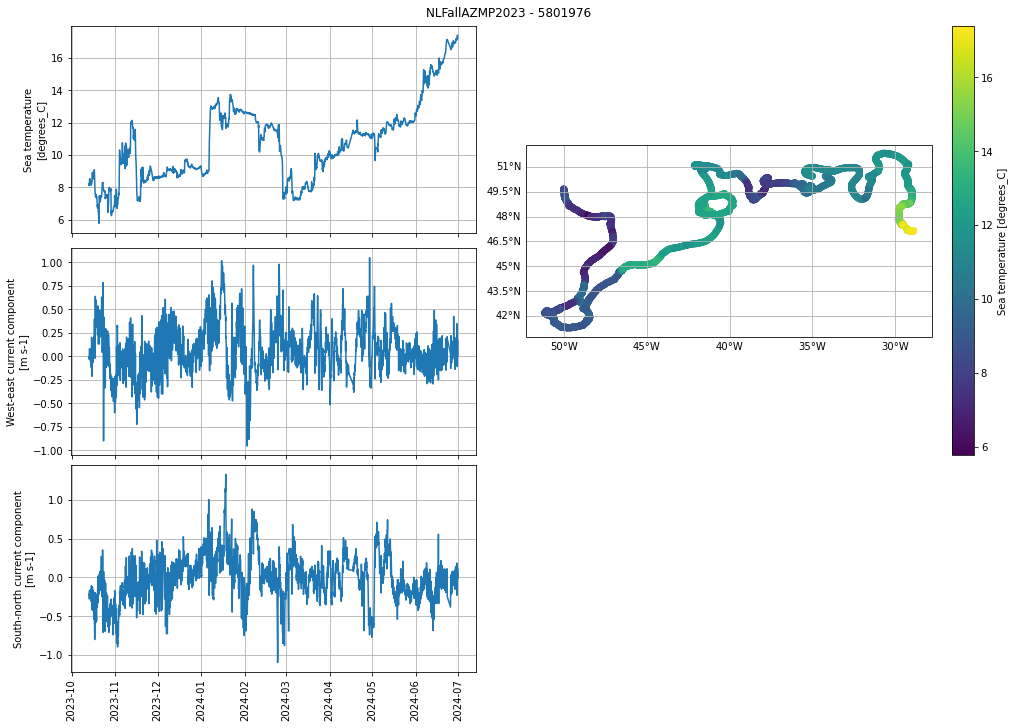

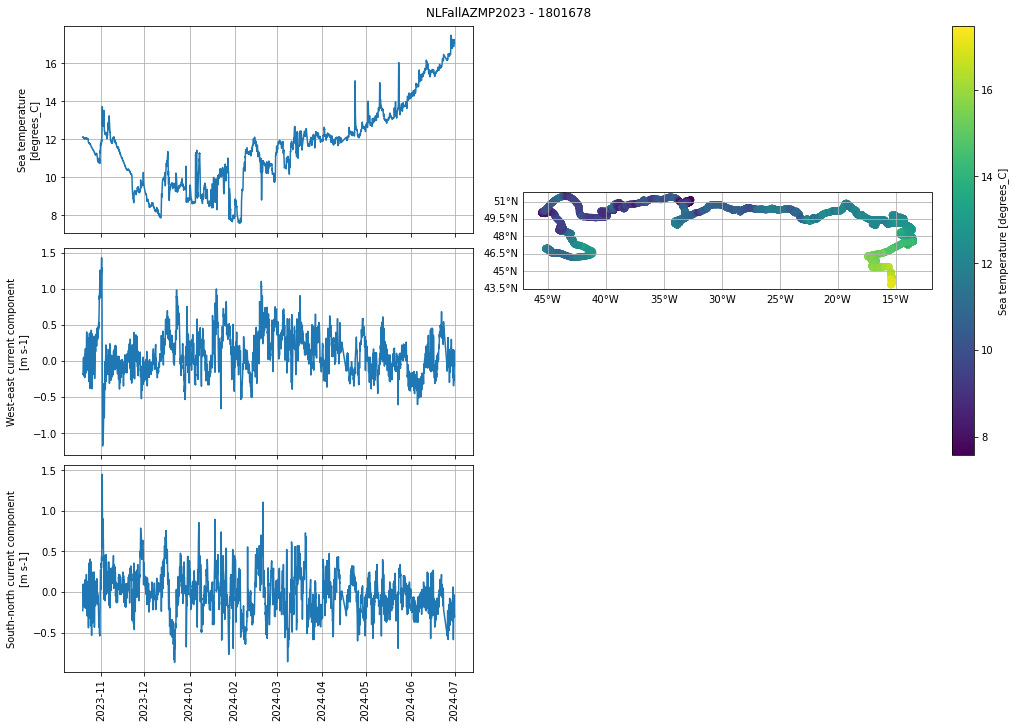

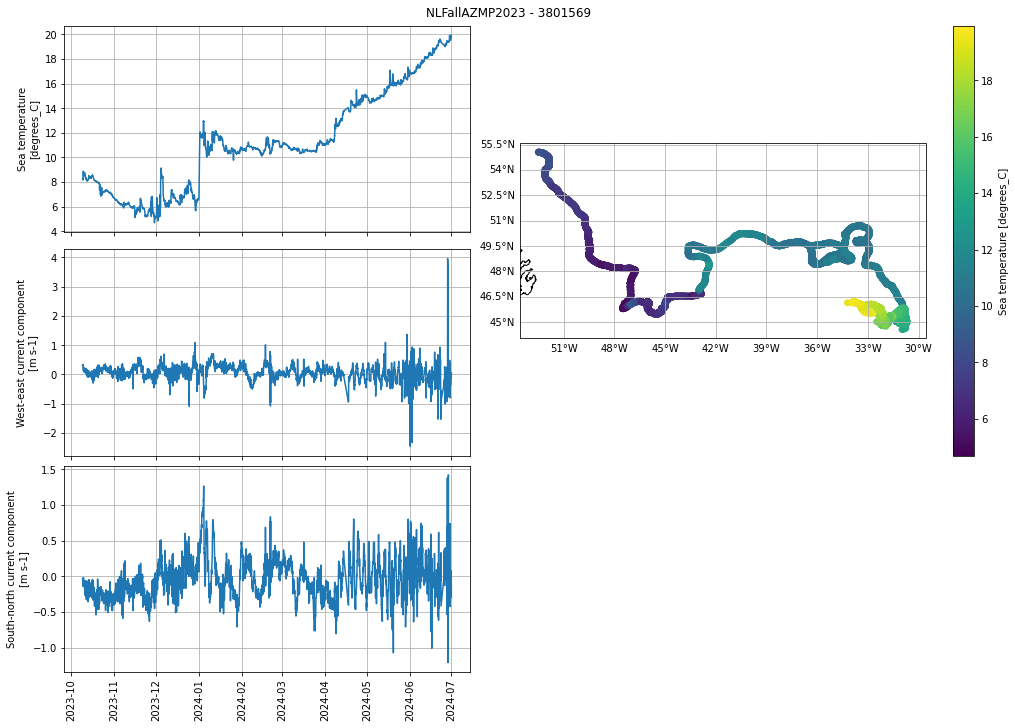

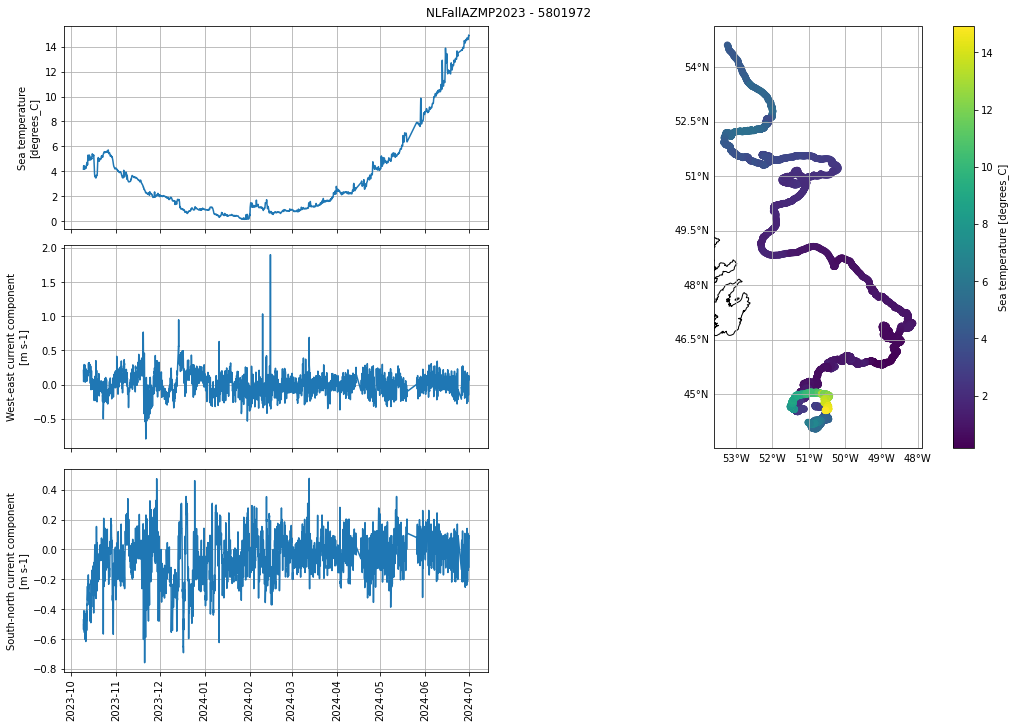

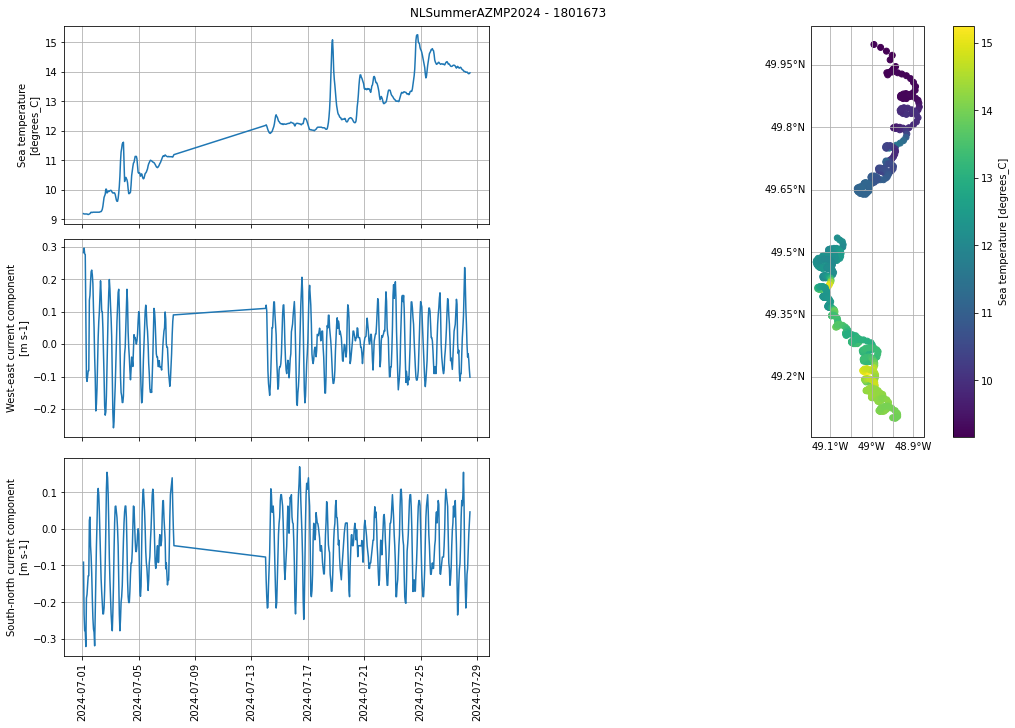

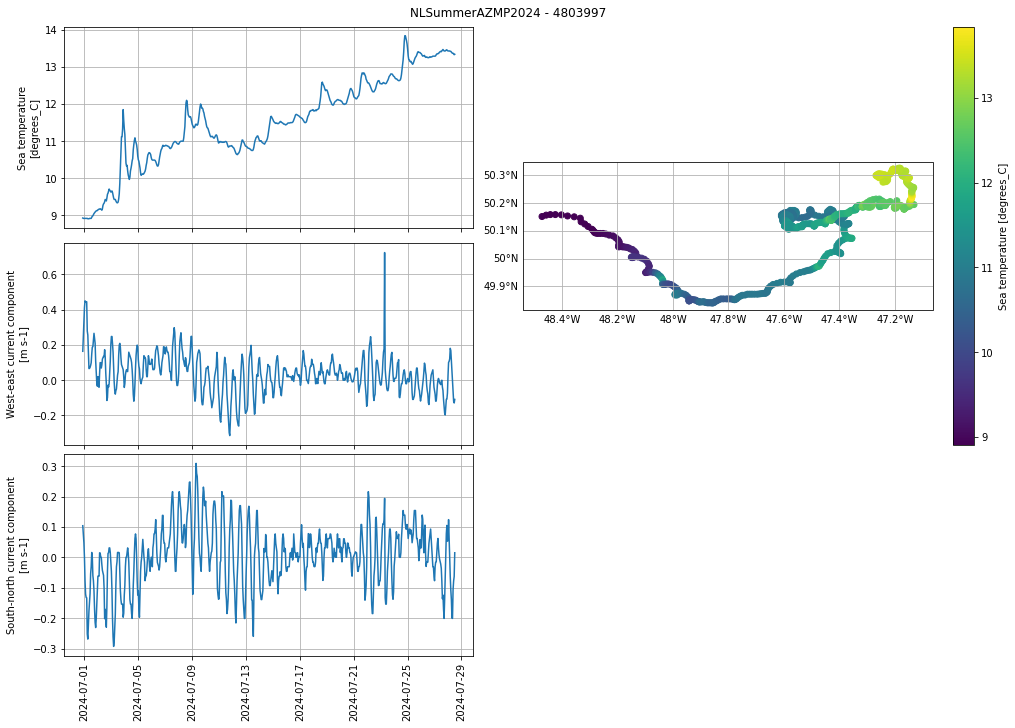

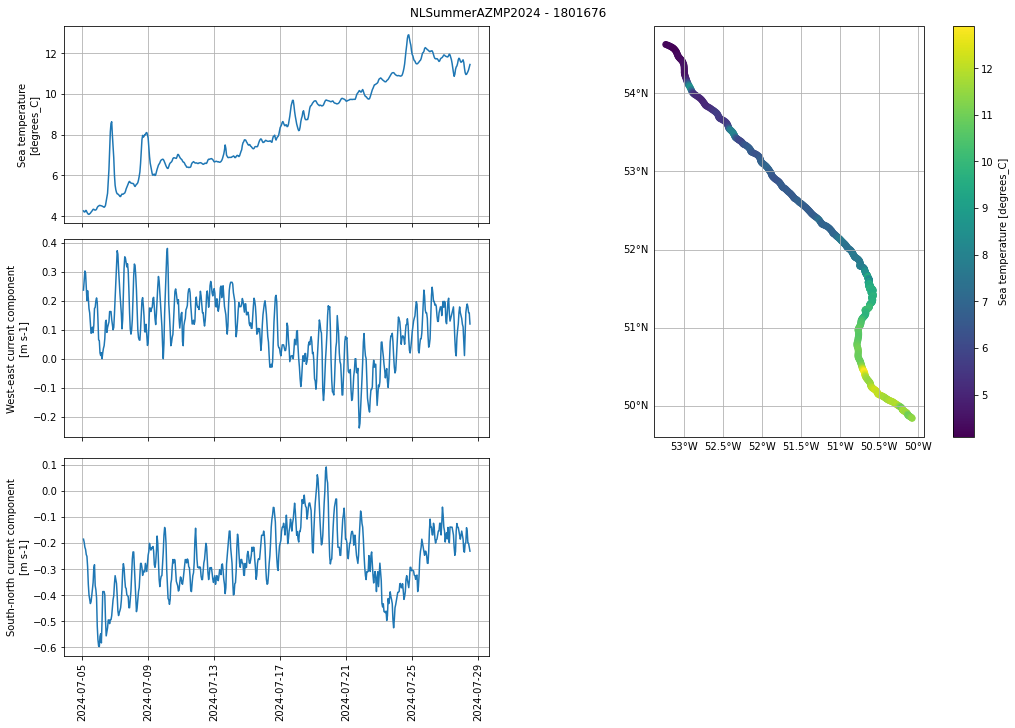

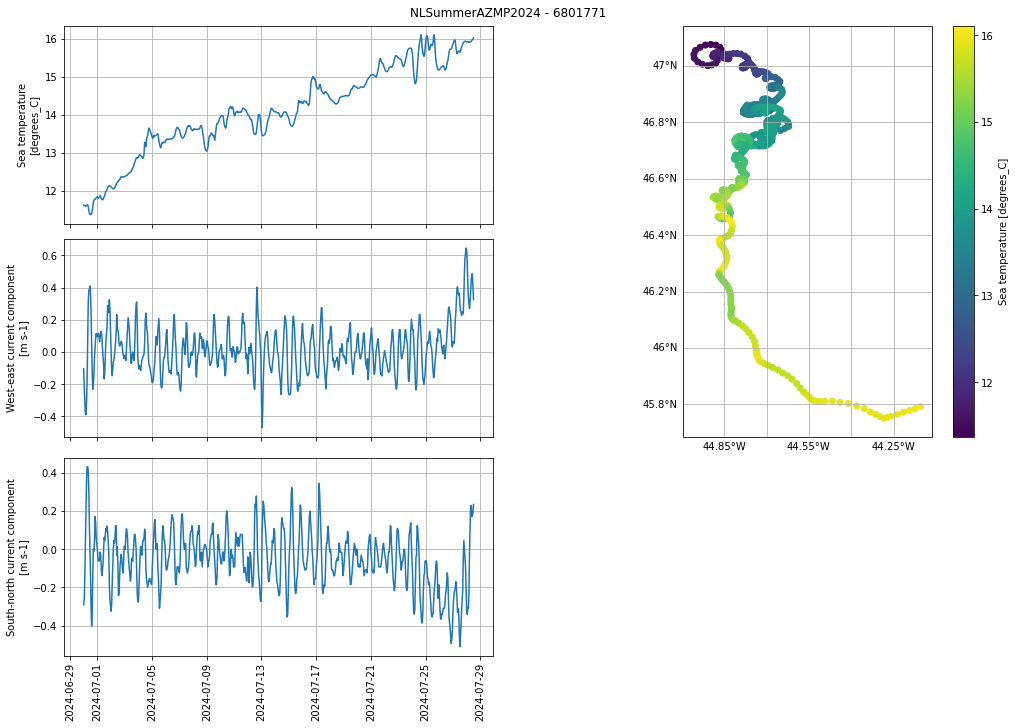

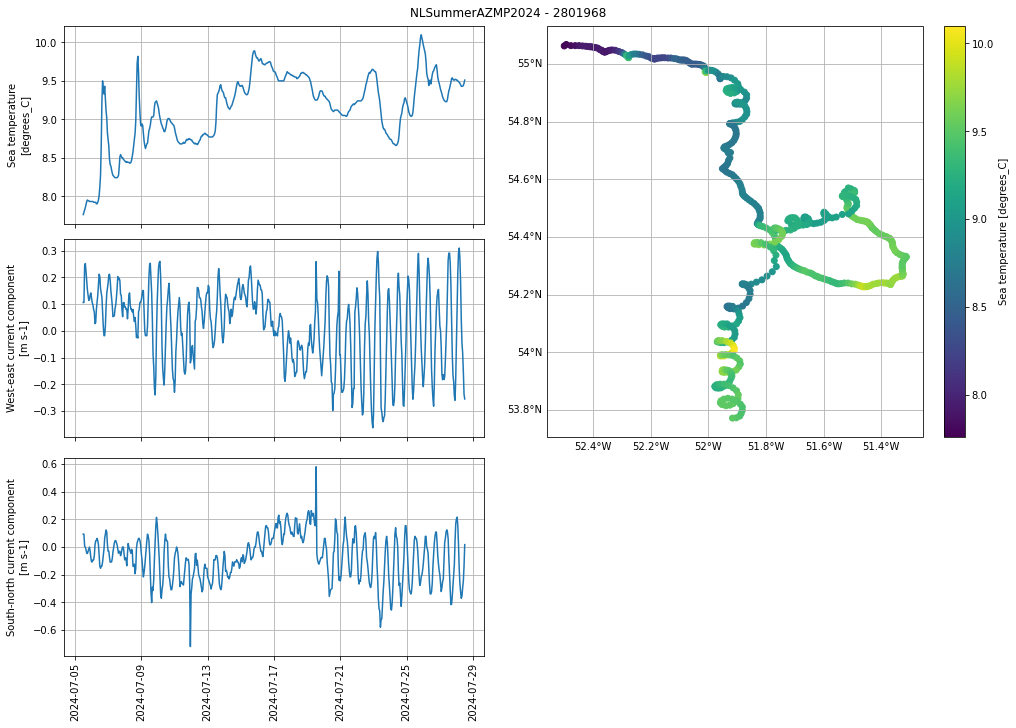

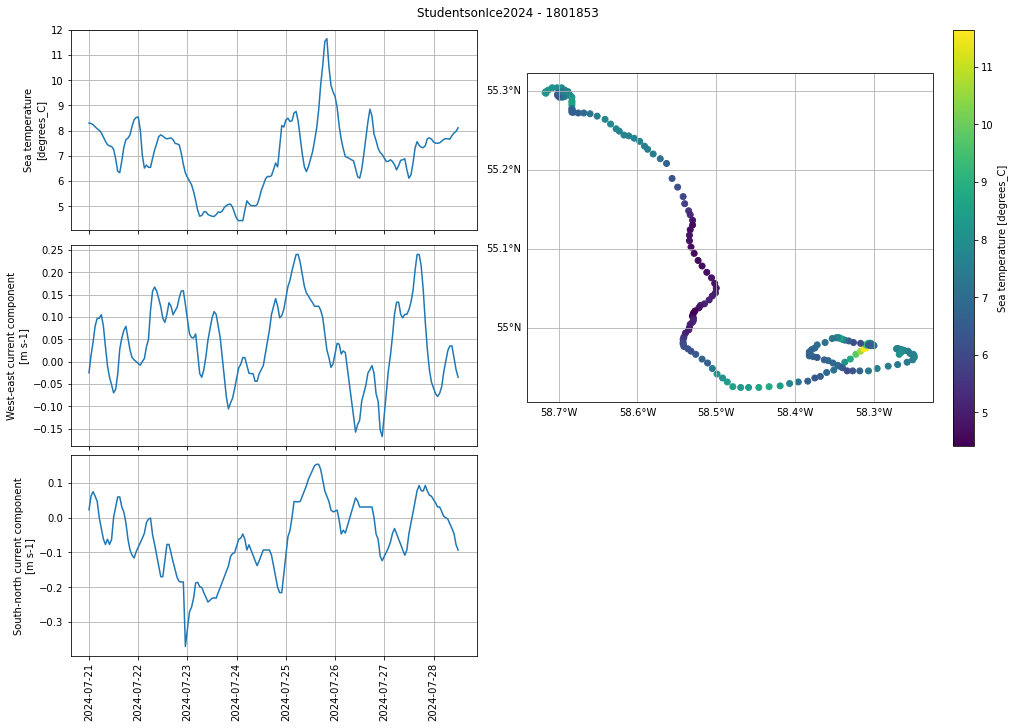

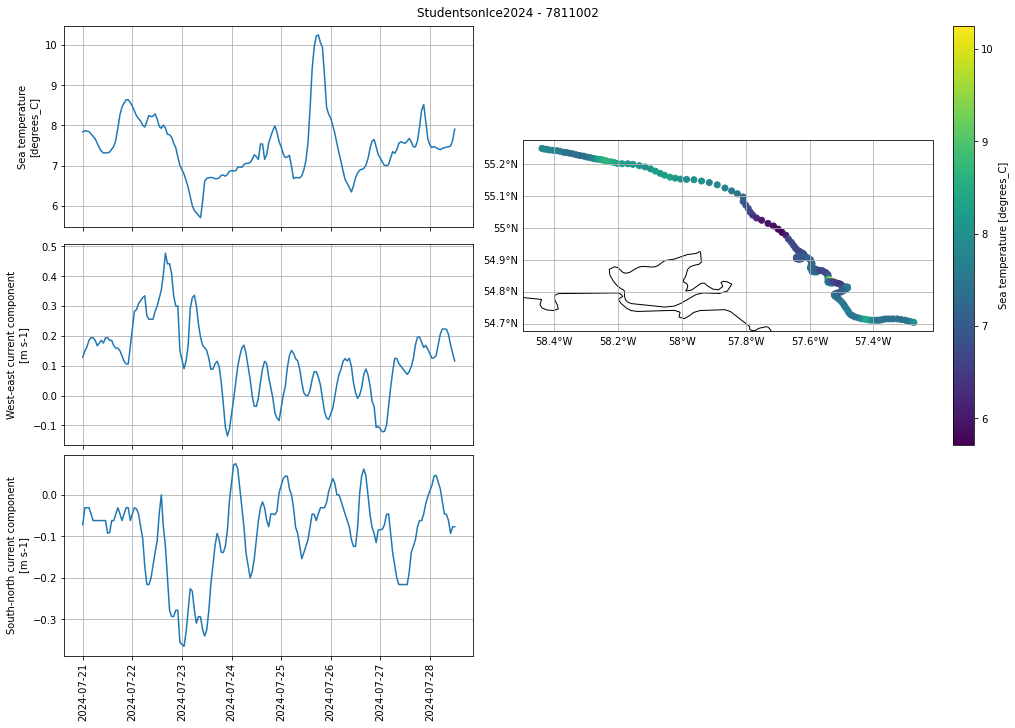

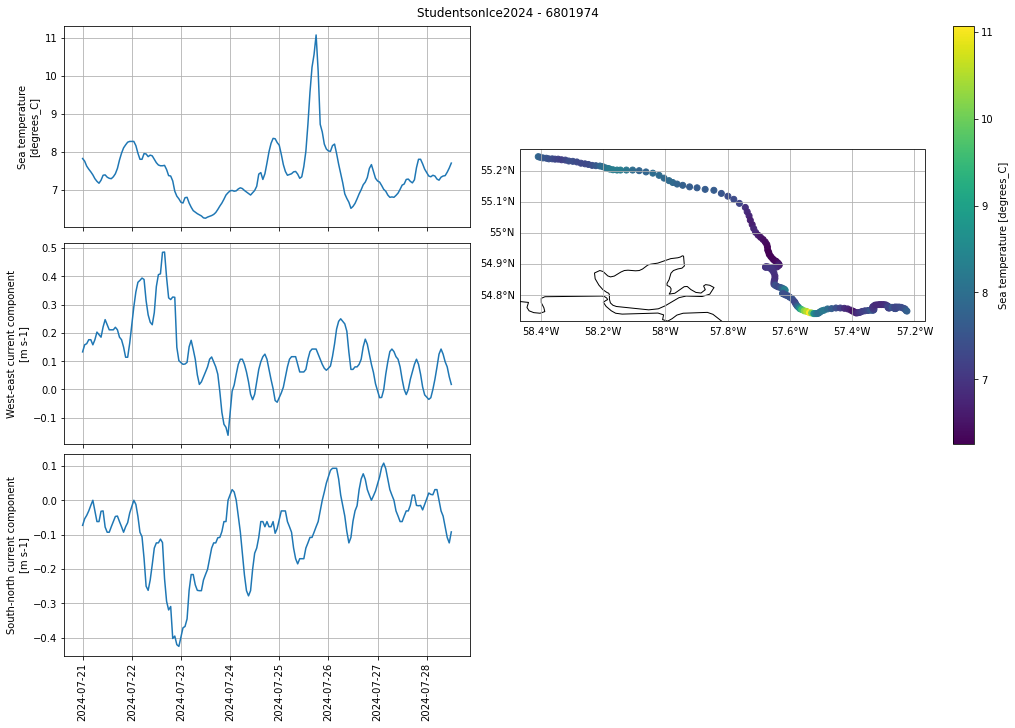

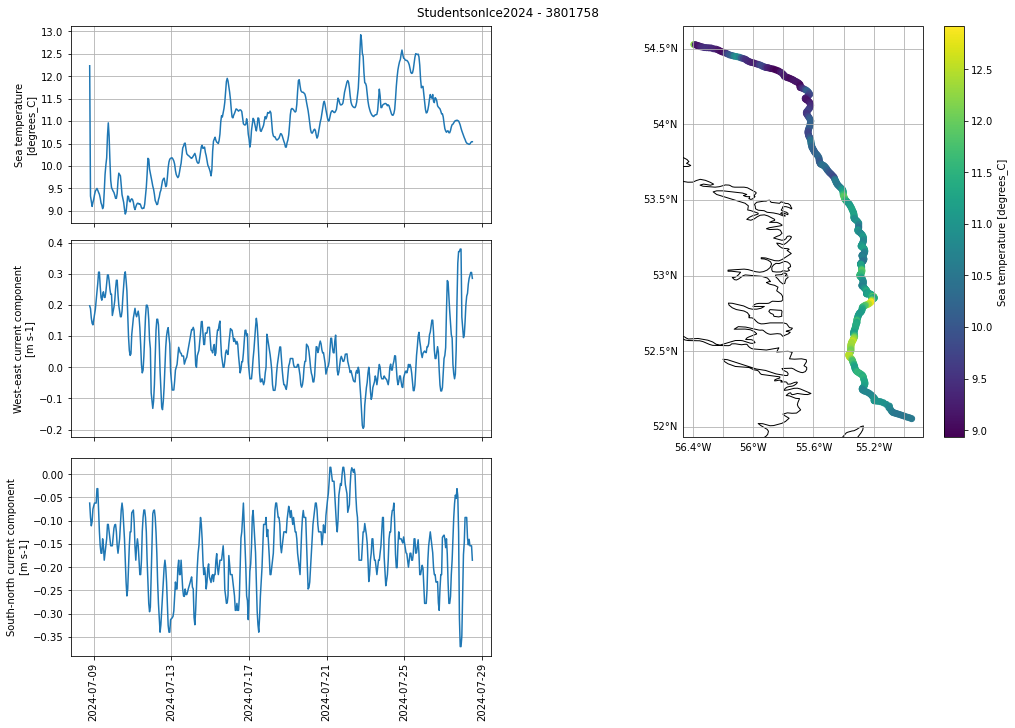

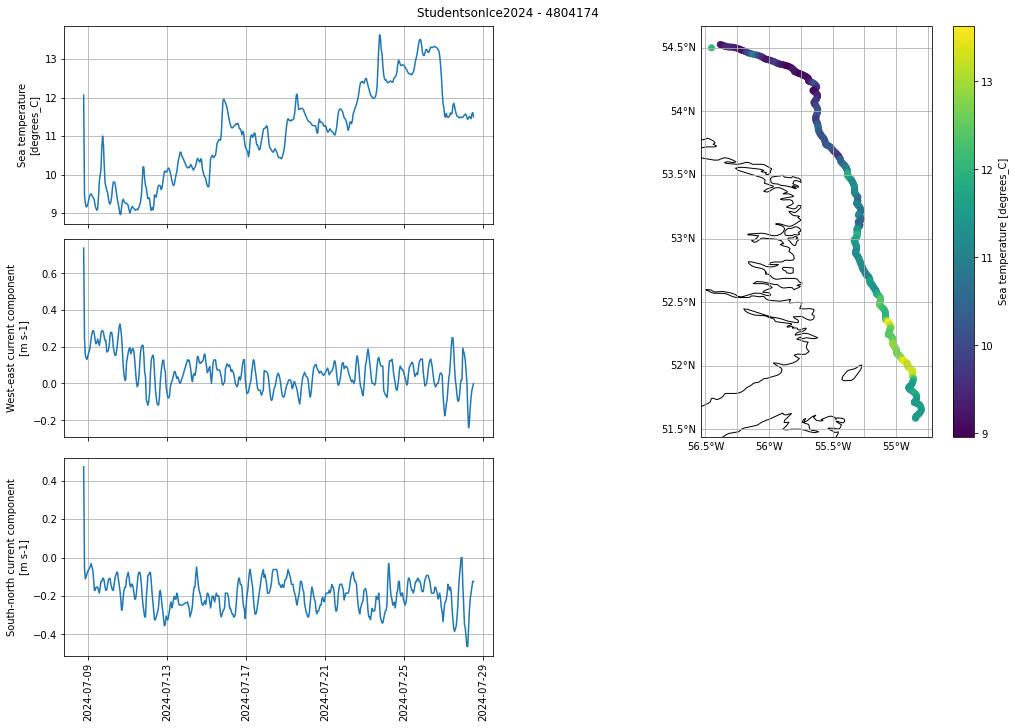

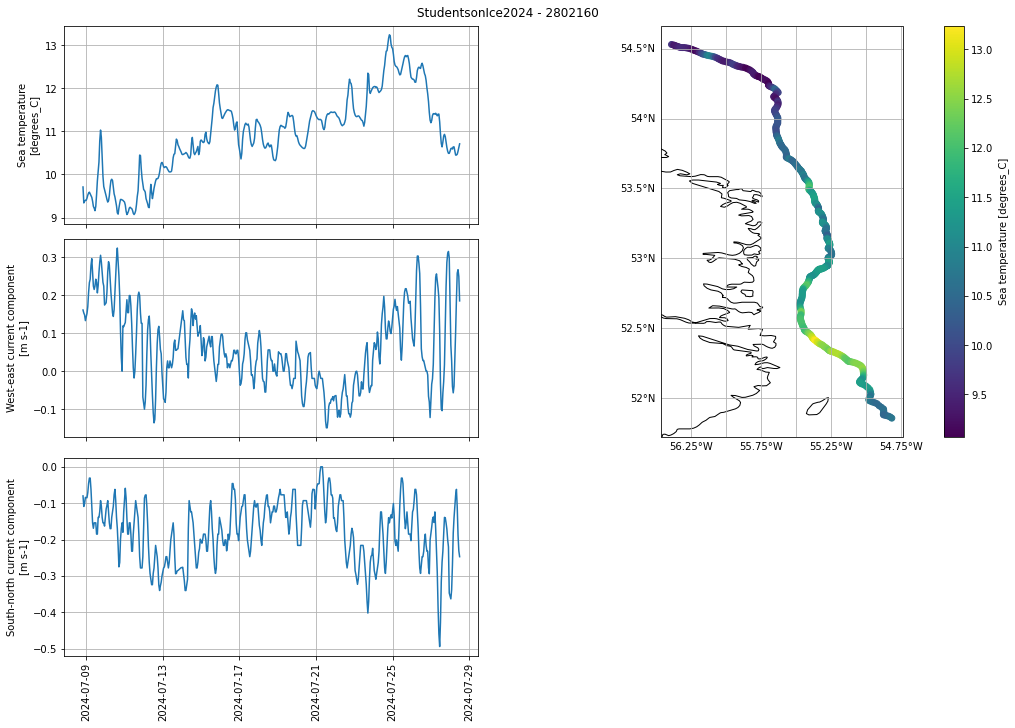

In [9]:
for dep in ds:
    IDs = deployments[dep]
    for ID in IDs:
        d = gather_data(ID)
        if not d:
            continue
        f = plot_gridspec(d)
        f.suptitle(f'{dep} - {ID}')